# setup

In [1]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tuning_fun as tu
import emulator_fun as ef
import numpy as np
from tqdm.keras import TqdmCallback
import pandas as pd
import time
import netCDF4 as nc
import load_ppe_fun as lp

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print(gpus)
# if gpus:
#     try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)]  # in MB
#         )
#     except RuntimeError as e:
#         print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# HP tuning

## pre-processing

In [2]:
filename = 'rainshaft_N10000_dt300.nc'

param_all_idx = np.arange(39)
# REVIEW: check every time if this is true ... not sure how to implement this programatically
# param_interest_idx = np.arange(16,28)
param_interest_idx = np.arange(28,39)
# param_interest_idx = np.arange(0,28)
# param_interest_idx = np.arange(12)
# param_interest_idx = np.concatenate((np.arange(0,8), np.arange(16,28)))

param_train = ef.get_params(lp.nc_dir, filename, param_interest_idx)

In [3]:
nppe, npar = param_train['vals'].shape

In [4]:
dataset = nc.Dataset(lp.nc_dir + filename, mode='r')

In [5]:
eff0s = getattr(dataset, 'thresholds_eff0')
var_constraints = getattr(dataset, 'var_constraints')
ppe_var_names = ['boss_' + i for i in var_constraints]
ppe_raw_vals = [dataset.variables[i][:] for i in ppe_var_names]
tgt_var_names = ['bin_' + i for i in var_constraints]
tgt_raw_vals = [dataset.variables[i][:] for i in tgt_var_names]

In [6]:
var_constraints

['mean_V_nc',
 'mean_V_qc',
 'mean_V_qx',
 'mean_V_qy',
 'V_nc',
 'V_qc',
 'V_qx',
 'V_qy']

In [7]:
np.product(ppe_raw_vals[4].shape[1:])

720

In [8]:
nobs = int(sum([ppe_raw_vals[i].size for i in range(len(var_constraints))])/nppe)
ncases = tgt_raw_vals[0].shape[0]

In [9]:
# ppe_var_presence = ppe_asinh = ppe_all = np.empty((nppe,0), dtype=np.float32)
# tgt_var_presence = tgt_asinh = tgt_all = np.empty((ncases,0), dtype=np.float32)

# for idx, eff0 in enumerate(eff0s):
#     if ppe_raw_vals[idx].ndim >= 2:
#         ppe_raw_val_reshaped = np.reshape(ppe_raw_vals[idx], (nppe, np.prod(ppe_raw_vals[idx].shape[1:])))
#         tgt_raw_val_reshaped = np.reshape(tgt_raw_vals[idx], (ncases, np.prod(tgt_raw_vals[idx].shape[1:])))
#     else:
#         ppe_raw_val_reshaped = ppe_raw_vals[idx].reshape(-1, 1)
#         tgt_raw_val_reshaped = tgt_raw_vals[idx].reshape(-1, 1)
#     ppe_var_presence = np.concatenate((ppe_var_presence, ppe_raw_val_reshaped > eff0s[idx]/100), axis=1)
#     ppe_asinh_reshaped = ef.smooth_linlog(ppe_raw_val_reshaped, eff0)
#     ppe_asinh = np.concatenate((ppe_asinh, ppe_asinh_reshaped), axis=1)
#     tgt_var_presence = np.concatenate((tgt_var_presence, tgt_raw_val_reshaped > eff0s[idx]/100), axis=1)
#     tgt_asinh_reshaped = ef.smooth_linlog(tgt_raw_val_reshaped, eff0)
#     tgt_asinh = np.concatenate((tgt_asinh, tgt_asinh_reshaped), axis=1)

# standscale = preprocessing.StandardScaler().fit(ppe_asinh)
# ppe_all = standscale.transform(ppe_asinh)
# tgt_all = standscale.transform(tgt_asinh)

In [10]:
from sklearn import preprocessing

minmaxscale = preprocessing.MinMaxScaler().fit(param_train['vals'])
x_all = minmaxscale.transform(param_train['vals'])

ppe_var_presence = []
ppe_data = []
tgt_var_presence = []
tgt_data = []

idx = 0
eff0 = eff0s[idx]
for idx, eff0 in enumerate(eff0s):
    if ppe_raw_vals[idx].ndim >= 2:
        ppe_raw_val_reshaped = np.reshape(ppe_raw_vals[idx], (nppe, np.prod(ppe_raw_vals[idx].shape[1:])))
        tgt_raw_val_reshaped = np.reshape(tgt_raw_vals[idx], (ncases, np.prod(tgt_raw_vals[idx].shape[1:])))
    else:
        ppe_raw_val_reshaped = ppe_raw_vals[idx].reshape(-1, 1)
        tgt_raw_val_reshaped = tgt_raw_vals[idx].reshape(-1, 1)

    ppe_var_presence.append(ppe_raw_val_reshaped > eff0/100)
    tgt_var_presence.append(tgt_raw_val_reshaped > eff0/100)

    ppe_asinh = ef.smooth_linlog(ppe_raw_val_reshaped, eff0)
    tgt_asinh = ef.smooth_linlog(tgt_raw_val_reshaped, eff0)
    standscale = preprocessing.StandardScaler().fit(ppe_asinh)
    ppe_data.append(standscale.transform(ppe_asinh))
    tgt_data.append(standscale.transform(tgt_asinh))

In [11]:
len(ppe_var_presence), x_all.shape

(8, (10000, 12))

In [12]:
import sklearn.model_selection as mod_sec
y_train_wpresence = []
y_train_rawv = []
y_val_wpresence = []
y_val_rawv = []

x_train, x_val, _, _ = mod_sec.train_test_split(x_all, ppe_var_presence[0], test_size=0.2, random_state=1)

for ivar, (ppe_varp, ppe_varr) in enumerate(zip(ppe_var_presence, ppe_data)):
    _, _, y_train_wpresence_single, y_val_wpresence_single = mod_sec.train_test_split(x_all, ppe_varp, test_size=0.2, random_state=1)
    _, _, y_train_rawv_single, y_val_rawv_single = mod_sec.train_test_split(x_all, ppe_varr, test_size=0.2, random_state=1)
    y_train_wpresence.append(y_train_wpresence_single)
    y_train_rawv.append(np.nan_to_num(y_train_rawv_single, nan=-1001))
    y_val_wpresence.append(y_val_wpresence_single)
    y_val_rawv.append(np.nan_to_num(y_val_rawv_single, nan=-1001))


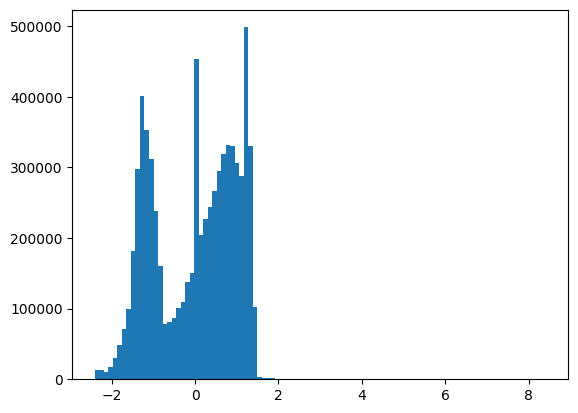

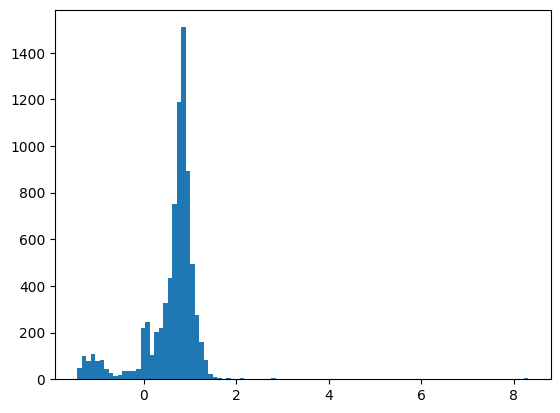

In [13]:
_ = plt.hist(ppe_data[4].flatten(), bins=100)
plt.figure()
_ = plt.hist(tgt_data[4].flatten(), bins=100)

## multi-head model

In [ ]:
nobs = [i.shape[1] for i in ppe_var_presence]
nvar = len(ppe_var_presence)

proj_name = 'try1_rainshaft_Vmx_multi-head'
tuner = kt.RandomSearch(
    lambda hp: tu.build_multihead_model(hp, npar, nvar, nobs),
    objective="val_loss",
    max_trials=50,
    directory=lp.bossppe_dir+'/hp_tuning/multi-head',
    project_name=proj_name,
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tuner.search(
    x_train,
    y_train_rawv,
    epochs=50,
    validation_data=(x_val, y_val_rawv),
    callbacks=([stop_early])
)

# Retrieve the best hyperparameters and build the best model:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

Reloading Tuner from /Users/arthurhu/github/BOSS_PPE//hp_tuning/multi-head/try1_rainshaft_Vmx_multi-head/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
5                 |5                 |num_shared_layers
192               |192               |units_0
2.0714e-06        |2.0714e-06        |adam_lr
0.0040172         |0.0040172         |lambda_mono
64                |64                |units_1
128               |128               |units_2

Epoch 1/50


2025-06-03 19:26:59.044489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step - loss: 64.5021 - output_scalar_0_loss: 7.9927 - output_scalar_0_mae: 0.8926 - output_scalar_1_loss: 8.8617 - output_scalar_1_mae: 0.9263 - output_scalar_2_loss: 8.5762 - output_scalar_2_mae: 0.8601 - output_scalar_3_loss: 8.1183 - output_scalar_3_mae: 0.8487 - output_scalar_4_loss: 7.6432 - output_scalar_4_mae: 0.8619 - output_scalar_5_loss: 7.7562 - output_scalar_5_mae: 0.8672 - output_scalar_6_loss: 7.8064 - output_scalar_6_mae: 0.8617 - output_scalar_7_loss: 7.7473 - output_scalar_7_mae: 0.8649 - val_loss: 60.6767 - val_output_scalar_0_loss: 7.6707 - val_output_scalar_0_mae: 0.8833 - val_output_scalar_1_loss: 8.1042 - val_output_scalar_1_mae: 0.9219 - val_output_scalar_2_loss: 7.7789 - val_output_scalar_2_mae: 0.8608 - val_output_scalar_3_loss: 7.3108 - val_output_scalar_3_mae: 0.8401 - val_output_scalar_4_loss: 7.4116 - val_output_scalar_4_mae: 0.8544 - val_output_scalar_5_loss: 7.4227 - val_output_scalar_5_mae: 0.8610 - val_output_scalar

KeyboardInterrupt: 

## multi-output model

In [18]:
proj_name = 'try15_rainshaft_Vmx_r1'
tuner = kt.RandomSearch(
    lambda hp: tu.build_classreg_model(hp, npar, nobs),
    objective="val_loss",
    max_trials=50,
    directory=lp.bossppe_dir+'/hp_tuning_withclass/multi-output',
    project_name=proj_name,
)


stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tuner.search(
    x_train,
    {'presence': y_train_wpresence, 'water': y_train},
    epochs=50,
    validation_data=(x_val, {'presence': y_val_wpresence, 'water': y_val}),
    callbacks=([stop_early])
)

# Retrieve the best hyperparameters and build the best model:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)



Trial 22 Complete [00h 00m 40s]
val_loss: 0.5594142079353333

Best val_loss So Far: 0.46970227360725403
Total elapsed time: 00h 27m 00s

Search: Running Trial #23

Value             |Best Value So Far |Hyperparameter
3                 |1                 |num_shared_layers
32                |128               |units_0
0.00063345        |0.00075076        |adam_lr
32                |96                |units_1
32                |256               |units_2
64                |224               |units_3
224               |192               |units_4

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1.3711 - presence_accuracy: 0.0048 - presence_loss: 0.4437 - water_loss: 0.9274 - water_mae: 0.7476 - val_loss: 0.7777 - val_presence_accuracy: 0.0575 - val_presence_loss: 0.2040 - val_water_loss: 0.5730 - val_water_mae: 0.5480
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.6564 - presence_accuracy: 0.1880 - presence_loss: 0.1761 - water_loss: 0.4802 - water_mae: 0.5087 

KeyboardInterrupt: 

In [ ]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 224)       │      2,912 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 224)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence (Dense)    │ (None, 2884)      │    648,900 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ raw_rate (Dense)    │ (None, 2884)      │    648,900 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ water (Multiply)    │ (None, 2884)      │          0 │ presence[0][0],   │
│                     │                   │            │ raw_rate[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,300,712 (4.96 MB)

 Trainable params: 1,300,712 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_presence_accuracy', mode='max', patience=1000)

train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, {'presence': y_train_wpresence, 'water': y_train}))
                 .shuffle(buffer_size=len(x_train))
                 .cache()
                 .batch(32)
                 .prefetch(tf.data.AUTOTUNE))

val_dataset = (tf.data.Dataset.from_tensor_slices((x_val, {'presence': y_val_wpresence, 'water': y_val}))
               .cache()
               .batch(32)
               .prefetch(tf.data.AUTOTUNE))

history = best_model.fit(
    train_dataset,
    epochs=10000,
    verbose=0,
    validation_data=val_dataset,
    callbacks=[TqdmCallback(verbose=1), stop_early]
)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2025-05-28 17:04:38.543914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


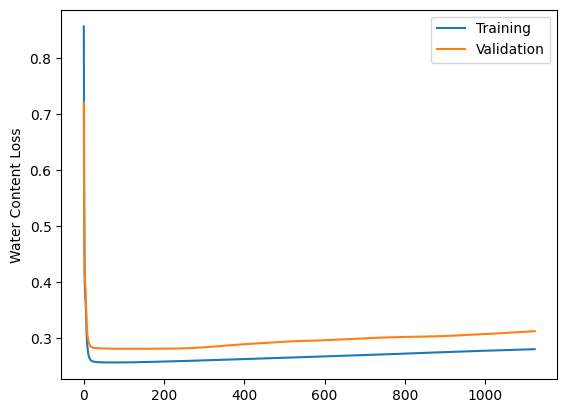

In [ ]:
plt.figure()
plt.plot(history.epoch, history.history['presence_accuracy'], label='Training')
plt.plot(history.epoch, history.history['val_presence_accuracy'], label='Validation')
plt.ylabel('Water Presence Accuracy')
plt.legend()

plt.figure()
plt.plot(history.epoch, history.history['water_loss'], label='Training')
plt.plot(history.epoch, history.history['val_water_loss'], label='Validation')
plt.ylabel('Water Content Loss')
plt.legend()

In [ ]:
# save model:
best_model.save(lp.bossppe_dir + '/models/multioutput_' + proj_name + '.keras')

## validation

In [18]:
best_model = tf.keras.models.load_model('models/multioutput_try1_rainshaft_Vmx.keras', compile=False)

2025-06-02 18:37:32.984092: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-06-02 18:37:32.984124: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-06-02 18:37:32.984132: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
I0000 00:00:1748903852.984403 90576663 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1748903852.984612 90576663 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 224)       │      2,912 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     28,800 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │     33,024 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ presence (Dense)    │ (None, 2884)      │    741,188 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ water (Dense)       │ (None, 2884)      │    741,188 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,547,112 (5.90 MB)

 Trainable params: 1,547,112 (5.90 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
best_model(x_val)[0]

<tf.Tensor: shape=(2000, 2884), dtype=float32, numpy=
array([[1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 4.6694422e-09,
        4.5480006e-09, 3.9844212e-09],
       [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 1.2090952e-12,
        1.4392909e-12, 1.4115951e-12],
       [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 2.4405965e-11,
        2.9824497e-11, 1.9236978e-11],
       ...,
       [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 1.6788507e-09,
        1.6183209e-09, 1.3567174e-09],
       [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 2.9347230e-10,
        3.2477546e-10, 2.9305278e-10],
       [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 7.9952035e-12,
        9.6082899e-12, 9.3595956e-12]], dtype=float32)>

In [21]:
best_model(x_val)[1].numpy()

array([[ 2.4940650e-01,  3.6517540e-01,  7.3748600e-01, ...,
        -3.0051477e-03,  8.0536585e-03,  5.2298687e-04],
       [ 1.1337698e+00,  8.3206820e-01,  7.8408837e-01, ...,
         9.0766011e-04,  5.8908993e-03,  2.5573070e-03],
       [-6.4799029e-01, -6.1129856e-01,  1.6488066e-01, ...,
        -9.1097318e-03, -2.7131112e-03,  2.0909183e-02],
       ...,
       [-1.5282834e+00, -1.5787884e+00, -2.0393891e+00, ...,
         3.5879177e-03, -1.7598877e-03,  2.3432621e-03],
       [ 1.1632316e+00,  8.3084685e-01,  7.8951573e-01, ...,
         2.7465017e-03,  6.3115675e-03, -1.6356484e-03],
       [ 1.2359788e+00,  8.2190651e-01,  7.8204662e-01, ...,
         9.3466195e-04,  8.1254030e-03,  1.2510290e-03]], dtype=float32)

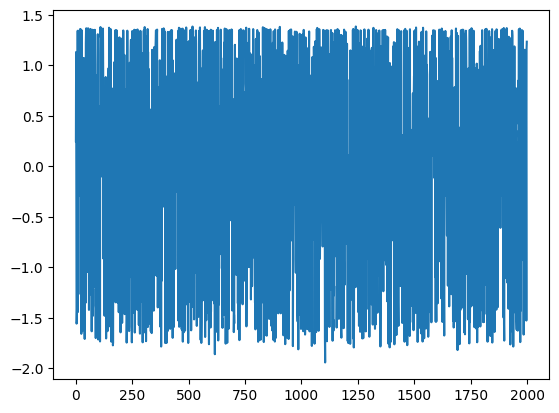

In [22]:
# best_model = tf.keras.models.load_model('models/multioutput_try28_condcoll_fullmom_nopartition_asinh.keras', compile=False)
plt.plot(best_model(x_val)[1][:,0])
# cc_model(x_val)[1]

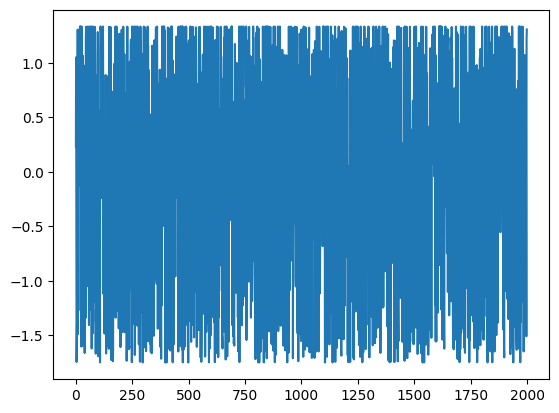

In [23]:
plt.plot(y_val[:,0])

In [24]:
best_model(x_val)

[<tf.Tensor: shape=(2000, 2884), dtype=float32, numpy=
 array([[1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 4.6694422e-09,
         4.5480006e-09, 3.9844212e-09],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 1.2090952e-12,
         1.4392909e-12, 1.4115951e-12],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 2.4405965e-11,
         2.9824497e-11, 1.9236978e-11],
        ...,
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 1.6788507e-09,
         1.6183209e-09, 1.3567174e-09],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 2.9347230e-10,
         3.2477546e-10, 2.9305278e-10],
        [1.0000000e+00, 1.0000000e+00, 1.0000000e+00, ..., 7.9952035e-12,
         9.6082899e-12, 9.3595956e-12]], dtype=float32)>,
 <tf.Tensor: shape=(2000, 2884), dtype=float32, numpy=
 array([[ 2.4940650e-01,  3.6517540e-01,  7.3748600e-01, ...,
         -3.0051477e-03,  8.0536585e-03,  5.2298687e-04],
        [ 1.1337698e+00,  8.3206820e-01,  7.8408837e-01

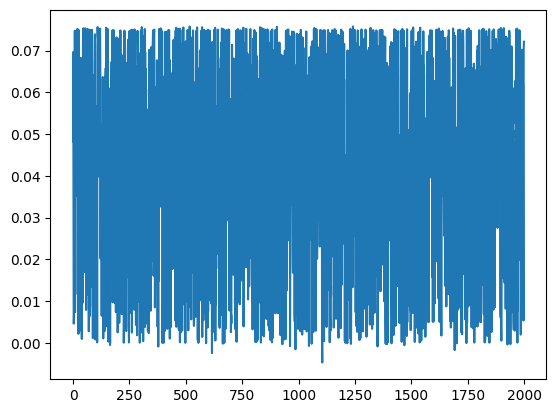

In [25]:
y_pred = standscale.inverse_transform(best_model(x_val)[1].numpy()) * best_model(x_val)[0]
# y_pred = model(x_val)
plt.plot(y_pred[:,0])

In [26]:
standscale.inverse_transform(y_train)

array([[0.03671404, 0.05899807, 0.06477231, ..., 0.        , 0.        ,
        0.        ],
       [0.05167278, 0.07311256, 0.07293458, ..., 0.        , 0.        ,
        0.        ],
       [0.04280136, 0.05502529, 0.07018095, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00641977, 0.02930586, 0.03654624, ..., 0.        , 0.        ,
        0.        ],
       [0.01176142, 0.02984851, 0.03592019, ..., 0.        , 0.        ,
        0.        ],
       [0.05064336, 0.0707688 , 0.07423362, ..., 0.        , 0.        ,
        0.        ]])

In [33]:
var_len = [int(np.prod(ppe_raw_vals[i].shape[1:])) for i in range(len(ppe_raw_vals))]
itr = list([np.arange(0, var_len[0])])
for ivlen, vlen in enumerate(var_len[1:]):
    itr.append(np.arange(itr[ivlen][-1]+1, itr[ivlen][-1]+1+vlen))
y_pred = standscale.inverse_transform(best_model(x_val)[1].numpy()) * best_model(x_val)[0].numpy()
y_val_lin = standscale.inverse_transform(y_val)

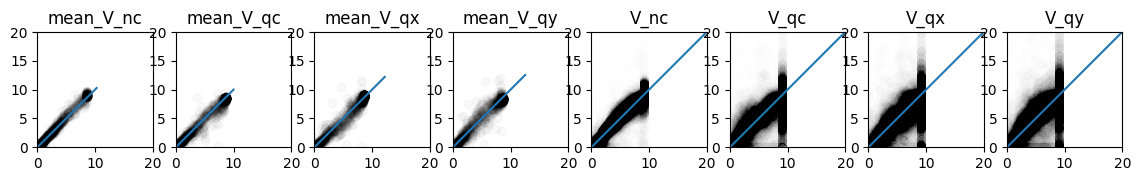

In [40]:



fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(1,8)
ivar = 0
for i in range(len(eff0s)):
    ax = fig.add_subplot(gs[i])
    ax.set_aspect('equal')

    vlen = y_val_lin[:,itr[i]].size
    alpha = max(1/np.sqrt(vlen), 0.002)
    if i < 4:
        plt.scatter(ef.inv_smooth_linlog(y_val_lin[:,itr[i]].flatten(),eff0s[i]), ef.inv_smooth_linlog(y_pred[:,itr[i]].flatten(), eff0s[i]), alpha=alpha, c='k')
    else:
        plt.scatter(ef.inv_smooth_linlog(y_val_lin[:,itr[i]].flatten()[::10], eff0s[i]), 
                    ef.inv_smooth_linlog(y_pred[:,itr[i]].flatten()[::10],eff0s[i]), alpha=alpha, c='k')
    # plt.scatter(ppe_sim_valid['vals'][:,i], y_pred[:,i],alpha=0.2,c='k')
    # plt.scatter(y_val[:,i], y_pred[:,i],alpha=0.2,c='k')
    # plt.title(ppe_sim_train['var_names'][i])
    ax_min = min(list(ax.get_ylim() + ax.get_xlim()))
    ax_max = max(list(ax.get_ylim() + ax.get_xlim()))
    plt.plot([ax_min, ax_max], [ax_min, ax_max])
    plt.title(var_constraints[i])
    plt.xlim([0, 20])
    plt.ylim([0, 20])
    # ax.set_xscale('log')
    # ax.set_yscale('log')
# fig.tight_layout()
# plt.savefig(plot_dir + proj_name + '.png')

In [44]:
y_pred[:,0]

<tf.Tensor: shape=(2000,), dtype=float32, numpy=
array([0.04829198, 0.06967466, 0.02659416, ..., 0.00530988, 0.07038701,
       0.07214594], dtype=float32)>

(array([4.66689e+05, 0.00000e+00, 2.20000e+02, 2.99200e+03, 8.65800e+03,
        2.23230e+04, 3.73010e+04, 6.15870e+04, 9.49210e+04, 7.45309e+05]),
 array([-6.93889390e-18,  7.50659212e-03,  1.50131842e-02,  2.25197764e-02,
         3.00263685e-02,  3.75329606e-02,  4.50395527e-02,  5.25461449e-02,
         6.00527370e-02,  6.75593291e-02,  7.50659212e-02]),
 <BarContainer object of 10 artists>)

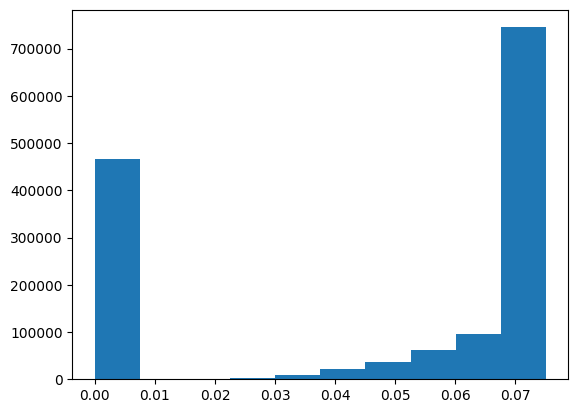

In [57]:
plt.hist(y_val_lin[:,itr[i]].flatten())

(array([1162.,  173.,  163.,   93.,   66.,   49.,   40.,   38.,   53.,
         163.]),
 array([-4.90642013e-03,  9.73937333e-01,  1.95278108e+00,  2.93162489e+00,
         3.91046858e+00,  4.88931227e+00,  5.86815596e+00,  6.84700012e+00,
         7.82584381e+00,  8.80468750e+00,  9.78353119e+00]),
 <BarContainer object of 10 artists>)

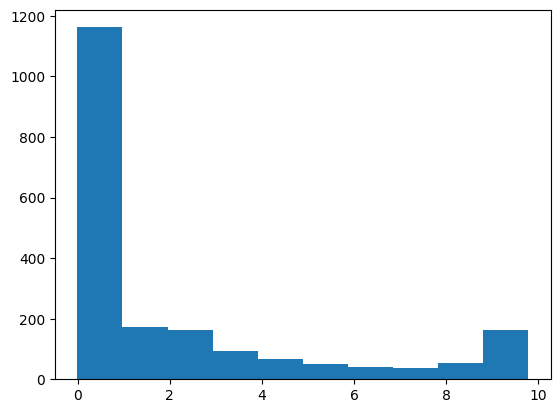

In [30]:
plt.hist(ef.inv_smooth_linlog(y_pred[:,itr[0]].flatten(), eff0s[0]))